# Twitter Sentiment Analysis

## Import libraries

In [1]:
import pandas, pickle, re, json, numpy
from os import listdir, mkdir, chdir
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from time import time
from pprint import pprint
import seaborn as sns

# for MLP warnings
import warnings
warnings.filterwarnings('ignore')

## Global variables for files, lists & dicts

In [2]:
TRAIN_DATA_PATH = '../sentiment_train_5k.csv'
TEST_DATA_PATH = '../sentiment_test_1k.csv'

print("Started the stopwatch...")
start_time = time()
TS_DB_Train = []        # tweet, sentiment database for training
TS_DB_Test = []         # tweet, sentiment database for testing
vocabulary = {}         # vocab dictionary

X_Train = []    # Training_Set , with features 
Y_Train = []    # Training_Result

X_Test = []     # Testing_Set , with features
Y_Test = []     # Testing_Result

BingLiuPositiveLexicons = {}    # +ve lexicon dict
BingLiuNegativeLexicons = {}    # -ve lexicon dict

accuracy = 0
accuracy_DB = []
confusion = [[0,0],[0,0]]       # confusion matrix


Started the stopwatch...


## Load required files
* **contractions.json** contains the list of contraction words, to be replaced in tweets
* All the models & stuff are saved in a new folder (if not already present) named **assets**
* **The BingLiu.csv** has been broken into 2 new files for +ve & -ve lexicons respectively 

In [3]:
## load contractions
with open('contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

## load lexicons
with open('BingLiuPositiveLexicons.txt') as f:
    for i in f:
        BingLiuPositiveLexicons[i.rstrip()]=True

with open('BingLiuNegativeLexicons.txt') as f:
    for i in f:
        BingLiuNegativeLexicons[i.rstrip()]=True

# every saved stuff here
if 'assets' not in listdir():
    mkdir('assets')
chdir('assets')

print("Time to read contractions & lexicons ->",time() - start_time)


Time to read contractions & lexicons -> 0.010230541229248047


## Prerprocessing functions
* The **emoji** function replaces the emoji in tweet with either **positiveemoji** or **negetiveemoji**
* **The process_tweet** preprocesses the tweets into a new column in the dataframe

In [4]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet

punctuations = []

def process_tweet(tweet):
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])   # Replaces contractions
    
    punctuations.append(len(re.findall('!', tweet)) + len(re.findall('\?', tweet)))  # counts freq of '!' & '?'
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space    
    return tweet


## Preprocess Tweet_Sentiment_Training dataset
* Read the training set into pandas df (if not found in assets)
* Call preprocessing functions on the tweets column
* Make a new column for the resultant tweets
* Save the result in assets (else skip all simply load it)

In [5]:
if 'TS_DB_Train' not in listdir():
    # read traning dataset
    train_data = pandas.read_csv(TRAIN_DATA_PATH)

    # set "sentiment" & tweets as global var for training data
    sentiment = train_data.columns.values[0]
    tweet = train_data.columns.values[5]

    ##### preprocessing
    train_data['processed_tweet'] = numpy.vectorize(process_tweet)(train_data[tweet])


    # make TS_DB_Train
    for i in range(len(train_data[sentiment])):
        TS_DB_Train.append([train_data[sentiment][i],train_data['processed_tweet'][i]])

    # now save it
    with open('TS_DB_Train', 'wb') as f:
        pickle.dump(TS_DB_Train, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    print("Time to import + read + save training data ->",time() - start_time)
else:
    # load
    print('TS_DB_Train found! Loading it...')
    with open('TS_DB_Train', 'rb') as f:
        TS_DB_Train = pickle.load(f)

    print("Time to import + read + save training data ->",time() - start_time)
    

Time to import + read + save training data -> 0.30666232109069824


## Build the vocalulary
* For all words in all tweets, append the frequency of it's appearance in +ve & -ve sentiments
* Also, by default add 1, for smoothing
* Now save the vocabulary, else skip all & directly load it

In [6]:
# now build vocalbulary
if 'vocabulary.pickle' not in listdir():
    print('Vocabulary not found! building new one')
    for i in TS_DB_Train:
        words = list(map(str,i[1].split()))
        for j in words:
            if j in vocabulary:
                if i[0] == 4:   # if +ve, then add 1 to right side
                    vocabulary[j][1] += 1
                else:           # else -ve, then add 1 to left
                    vocabulary[j][0] += 1
            else:               # new word, add 1,1 for smoothing
                vocabulary[j] = [1,1]
                if i[0] == 4:
                    vocabulary[j][1] += 1
                else:
                    vocabulary[j][0] += 1
    # save vocabulary
    print('Saving the vocabulary in current dir...')
    with open('vocabulary.pickle', 'wb') as handle:
        pickle.dump(vocabulary, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    # load vocabulary from pickle
    print('Vocabulary found! Loading it...')
    with open('vocabulary.pickle', 'rb') as handle:
        vocabulary = pickle.load(handle)
        
print('Length of vocabulary ->',len(vocabulary))

print("Time to build vocabulary ->",time() - start_time)


Vocabulary not found! building new one
Saving the vocabulary in current dir...
Length of vocabulary -> 10554
Time to build vocabulary -> 0.36818385124206543


## Feature functions
1. check_elongation : Counts the freq of elongated words in a tweet
2. check_hashtag : Counts the freq of hashtags used in a tweet
3. check_CAPS : Counts the freq of CAPS words in a tweet
4. check_negation : Counts the freq of negative words in a tweet
5. check_p_emoji : Count the occurence of **positiveemoji** in a tweet
6. check_n_emoji : Count the occurence of **negativeemoji** in a tweet
7. check_p_lexicon : Count the freq of Positive Lexicons from BingLiu dataset
8. check_n_lexicon : Count the freq of Negative Lexicons from BingLiu dataset

* More features ahead like normalized score, punctuations, Count Vectorization (unigram + bigram)

In [7]:
############### features #################

def check_elongation(word):
    temp = re.sub(r'(.)\1+', r'\1\1', word)
    if len(temp) != len(word):
        return 1
    else:
        return 0

def check_hashtag(word):
    if word[0] != "#":
        return 0
    return 1

def check_CAPS(word):
    if word.isupper():
        return 1
    return 0

def check_negation(word):
    if word.lower() in ['not', 'no', 'nope', 'nopes', 'never', 'neither', 'nor', 'none']:
        return 1
    return 0

def check_p_emoji(word):
    if word == 'positiveemoji':
        return 1
    return 0

def check_n_emoji(word):
    if word == 'negativeemoji':
        return 1
    return 0

def check_p_lexicon(word):
    if word in BingLiuPositiveLexicons:
        return 1
    return 0

def check_n_lexicon(word):
    if word in BingLiuNegativeLexicons:
        return 1
    return 0

## Making X_Train & Y_Train
* Append a new empty list of features in **X_Train** for every tweet
* Fill the values in list by calling all the feature functions
* Also add a new **normalized_score_for_tweet** feature, by using the vocalbulary build earlier
* Add the new **punctuation** feature
* Add tweet sentiment results in **Y_Train**
* Save them, if already saved, skip everthing & directly load them

In [8]:
###### now make X_Train & Y_Train

if 'X_Train' not in listdir():

    print("Making X_Train & Y_Train from features.....")
    for i in TS_DB_Train:
                    #  [0,1,2,3,4,5,6,7,8]      # append 1 for punctuation after this loop
        X_Train.append([0,0,0,0,0,0,0,0,0])    # [normalized score for tweet, +ve lexicons, -ve lexicons, enlongated, hastag, allcaps, negation, +ve emoji, -ve emoji]   # append punctuation
        Y_Train.append(i[0])                       # [actual result]
        
        p_score = 1
        n_score = 1
        test_tweet = list(map(str,i[1].split()))
        for j in test_tweet:
            X_Train[-1][1] += check_p_lexicon(j)
            X_Train[-1][2] += check_n_lexicon(j)
            X_Train[-1][3] += check_elongation(j)
            X_Train[-1][4] += check_hashtag(j)
            X_Train[-1][5] += check_CAPS(j)
            X_Train[-1][6] += check_negation(j)
            X_Train[-1][7] += check_p_emoji(j)
            X_Train[-1][8] += check_n_emoji(j)
            
            
            if j in vocabulary:
                # total_score = vocabulary[j][0] + vocabulary[j][1]
                p_score*= vocabulary[j][1]
                n_score*= vocabulary[j][0]

        X_Train[-1][0] = p_score/(p_score+n_score)

    ####### add punctuation column
    for i in range(len(punctuations)-1):
        X_Train[i].append(punctuations[i])  # new column

    # now save
    with open('X_Train', 'wb') as f:
        pickle.dump(X_Train, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('Y_Train', 'wb') as f:
        pickle.dump(Y_Train, f, protocol=pickle.HIGHEST_PROTOCOL)

    print("Time to make X_Train & Y_Train ->",time() - start_time)
else:
    print("Found X_Train & Y_Train, loading...")
    with open('X_Train', 'rb') as f:
        X_Train = pickle.load(f)
    with open('Y_Train', 'rb') as f:
        Y_Train = pickle.load(f)

    print("Time to load saved X_Train, Y_Train ->",time() - start_time)
    
# pprint(X_Train)

Making X_Train & Y_Train from features.....
Time to make X_Train & Y_Train -> 0.8382604122161865


## Now make the Tweet_Sentiment_Testing dataset
* Read the testing dataset into pandas
* Perform the preprocessing
* Add the preprocessed tweet to new column
* Append Tweets & Sentiment to TS_DB_Test

In [9]:
########### Making TS_DB_Test

print("Now testing part starts...")

test_data = pandas.read_csv(TEST_DATA_PATH)

# set "sentiment" & tweets as global var for testing data
sentiment = test_data.columns.values[0]
tweet = test_data.columns.values[5]

######## preprocessing
punctuations = []
test_data['processed_tweet'] = numpy.vectorize(process_tweet)(test_data[tweet])


# make TS_DB_Test
for i in range(len(test_data[sentiment])):
    TS_DB_Test.append([test_data[sentiment][i],test_data['processed_tweet'][i]])

print("Time to import + read + save testing data ->",time() - start_time)


Now testing part starts...
Time to import + read + save testing data -> 0.901008129119873


## X_Test, Y_Test & impelementing Naive Bayes
* Append empty features list in **X_Test**
* Add new column for **punctuations**
* Append the sentiment results in **Y_Test**
* Calculate **normalized_score_for_tweet** using the vocalbulary
* Match the score with actual result
* If correct, increase the **accuracy**

In [10]:
######## making X_Test , Y_Test [IMPLEMENT NAIVE BAYES]

for i in range(len(TS_DB_Test) -1,-1,-1):
    try:
        p_score = 1
        n_score = 1
                    # [0,1,2,3,4,5,6,7,8,9]
        X_Test.append([0,0,0,0,0,0,0,0,0,0])        # [normalized score for tweet, +ve lexicons, -ve lexicons, enlongated, hastag, allcaps, negation, +ve emoji, -ve emoji] # append punctuation side by side
        test_tweet = list(map(str,TS_DB_Test[i][1].split()))
        for j in test_tweet:
            if j in vocabulary:
                # total_score = vocabulary[j][0] + vocabulary[j][1]
                p_score*= vocabulary[j][1]
                n_score*= vocabulary[j][0]
            
            X_Test[-1][1] += check_p_lexicon(j)
            X_Test[-1][2] += check_n_lexicon(j)
            X_Test[-1][3] += check_elongation(j)
            X_Test[-1][4] += check_hashtag(j)
            X_Test[-1][5] += check_CAPS(j)
            X_Test[-1][6] += check_negation(j)
            X_Test[-1][7] += check_p_emoji(j)
            X_Test[-1][8] += check_n_emoji(j)

        X_Test[-1][0] = p_score/(n_score+p_score)    # normalized score for tweet

        ####### add punctuation values
        X_Test[-1][9] = punctuations[i]

        if p_score > n_score:
            senti = 4
        else:
            senti = 0
        
        accuracy_DB.append(senti)          # append result to DB
        if senti == TS_DB_Test[i][0]:   # check with actual result
            accuracy += 1
        Y_Test.append(TS_DB_Test[i][0]) # append actual test result

    except:
        pass


## Result for Naive Bayes
* Print the accuracy for Naive Bayes approach
* Print the len of X/Y_Train, X/Y_Test
* Print the confusion matrix
* Print the precision, recall & macro-average F1 score

In [11]:
print("\nResult for Naive bayes ->")

print("Correct words = ",accuracy)
print("Total words = ",len(TS_DB_Test))
print("accuracy = ",(accuracy/len(TS_DB_Test))*100,'%') 
print("Time taken for naive bayes ->",time() - start_time)

print("len(X_Train) = {}, len(Y_Train) = {}, len(X_Test) = {}, len(Y_Test) = {}".format(len(X_Train),len(Y_Train),len(X_Test),len(Y_Test)))

# make confusion matrix
for i in range(len(accuracy_DB)):          # compare actual & predicted result
    if accuracy_DB[i] == Y_Test[i] == 4:
        confusion[1][1]+=1
    elif accuracy_DB[i] == Y_Test[i] == 0:
        confusion[0][0]+=1
    elif accuracy_DB[i] == 4 and Y_Test[i] == 0:
        confusion[0][1]+=1
    else:
        confusion[1][0]+=1

print("\nConfusion Matrix ->")
print("Row has the original values, while column represents the predicted values")
print('\t\tNegative\tPositive')
print('Negative\t',confusion[0][0],'\t\t',confusion[0][1])
print('Positive\t',confusion[1][0],'\t\t',confusion[1][1])

TP_POS = confusion[1][1]
FP_POS = confusion[0][1]
FN_POS = confusion[1][0]

TP_NEG = confusion[0][0]
FP_NEG = confusion[1][0]
FN_NEG = confusion[0][1]

print("\nFor positive sentiment ->")
precision = TP_POS / (TP_POS + FP_POS)
print("precision =",precision)
recall = TP_POS / (TP_POS + FN_POS)
print("recall = ",recall)
print("Macro average f1s = ",2*precision*recall/(precision+recall))
    


# naive bayes over now preapre for SVM


Result for Naive bayes ->
Correct words =  688
Total words =  999
accuracy =  68.86886886886887 %
Time taken for naive bayes -> 0.9973759651184082
len(X_Train) = 4999, len(Y_Train) = 4999, len(X_Test) = 999, len(Y_Test) = 999

Confusion Matrix ->
Row has the original values, while column represents the predicted values
		Negative	Positive
Negative	 391 		 70
Positive	 241 		 297

For positive sentiment ->
precision = 0.8092643051771117
recall =  0.5520446096654275
Macro average f1s =  0.6563535911602209


## Count Vectorization 
* Convert X/Y_Train, X/Y_Test to pandas DataFrame
* Read training + testing dataset, perform preprocessing
* Apply Count Vectorization on them (unigram + bigram)
* Convert the Vectorized data to pandas DataFrame
* Concatenate the Vectorzied DFs with their respective X_Train & X_Test DFs columnwise
* Save all the DFs, if already saved, skip everything & simply load them
<br><br>
+ Useful link - https://stackoverflow.com/questions/40370800/insert-result-of-sklearn-countvectorizer-in-a-pandas-dataframe

In [12]:

if 'X_Train_DF' not in listdir():
    print("Making DF & saving them...")
    X_Train_DF = pandas.DataFrame(X_Train)
    Y_Train_DF = pandas.DataFrame(Y_Train)
    X_Test_DF = pandas.DataFrame(X_Test)
    Y_Test_DF = pandas.DataFrame(Y_Test)

    print("Applying count vectorization!")
    count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
    
    train_data = pandas.read_csv(TRAIN_DATA_PATH)
    ############### preprocessing
    train_data['processed_tweet'] = numpy.vectorize(process_tweet)(train_data['5'])
    final_vectorized_data = count_vectorizer.fit_transform(train_data['processed_tweet'])

    # Convert sparse csr_matrix to dense format and allow columns to contain the array mapping from feature integer indices to feature names
    count_vect_df = pandas.DataFrame(final_vectorized_data.todense(), columns=count_vectorizer.get_feature_names())
    # Concatenate the original X_Train and the count_vect_df columnwise.
    X_Train_DF = pandas.concat([X_Train_DF, count_vect_df], axis=1)
    
    ##############
    
    test_data = pandas.read_csv(TEST_DATA_PATH)
    ############### preprocessing
    test_data['processed_tweet'] = numpy.vectorize(process_tweet)(test_data['5'])
    final_vectorized_data = count_vectorizer.transform(test_data['processed_tweet'])

    # Convert sparse csr_matrix to dense format and allow columns to contain the array mapping from feature integer indices to feature names
    count_vect_df = pandas.DataFrame(final_vectorized_data.todense(), columns=count_vectorizer.get_feature_names())
    # Concatenate the original X_Train and the count_vect_df columnwise.
    X_Test_DF = pandas.concat([X_Test_DF, count_vect_df], axis=1)

    with open('X_Train_DF', 'wb') as f:
        pickle.dump(X_Train_DF,f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('Y_Train_DF', 'wb') as f:
        pickle.dump(Y_Train_DF,f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('X_Test_DF', 'wb') as f:
        pickle.dump(X_Test_DF,f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('Y_Test_DF', 'wb') as f:
        pickle.dump(Y_Test_DF,f, protocol=pickle.HIGHEST_PROTOCOL)

    print("Time to make & save DFs, apply count vectorization ->",time() - start_time)    
else:
    X_Train_DF = pickle.load(open("X_Train_DF" ,"rb"))
    Y_Train_DF = pickle.load(open("Y_Train_DF" ,"rb"))
    X_Test_DF = pickle.load(open("X_Test_DF" ,"rb"))
    Y_Test_DF = pickle.load(open("Y_Test_DF" ,"rb"))
    print("Time to load saved DFs ->",time() - start_time)


Making DF & saving them...
Applying count vectorization!
Time to make & save DFs, apply count vectorization -> 4.7886998653411865


## Result for SVM
* Make SVM model using .fit(X_Train_DF, Y_Train)
* Save it, if already saved, skip above & load model
* Predict the accuracy using .score(X_Test_DF, Y_Test)
* Make Confusion matrix using heatmap
* Make Classification report on precision, recall & F1 score

#### SVM model is the slowest of all, took about 2.2 hours + 24GB RAM, for 10k tweets training & 5k tweets testing, so better to skip it for larger datasets
+ https://stackoverflow.com/questions/32199996/linux-using-swap-instead-of-ram-with-large-image-processing


Now SVM model.....
No saved model... Creating one!
Time to train & save model -> 843.4613010883331
Accuracy by SVM -> 69.96996996996997 %
Time taken to predict -> 1167.4428622722626


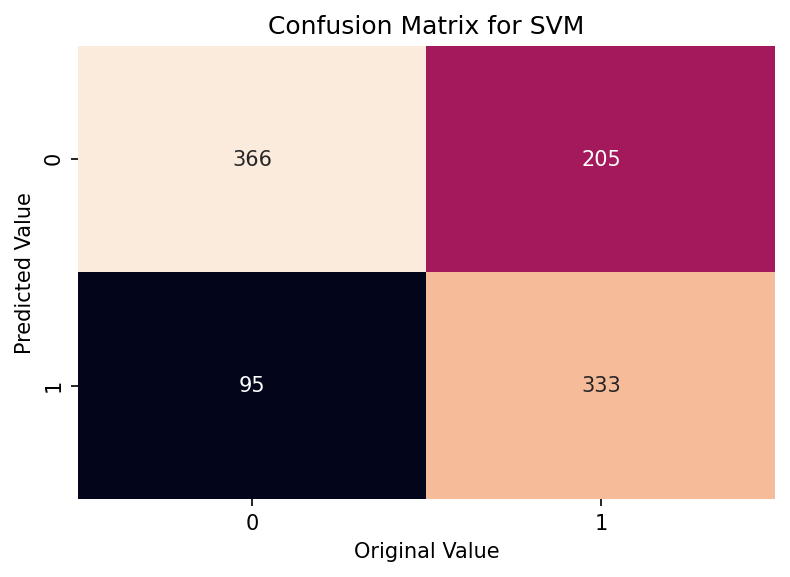

              precision    recall  f1-score   support

           0       0.64      0.79      0.71       461
           4       0.78      0.62      0.69       538

    accuracy                           0.70       999
   macro avg       0.71      0.71      0.70       999
weighted avg       0.71      0.70      0.70       999



In [13]:
#### SVM model

print("\nNow SVM model.....")
SVM_model = SVC()

if 'SVM_model' in listdir():
    SVM_model = pickle.load(open("SVM_model" ,"rb"))
    print("Time to load saved model...",time() - start_time)
else:
    print("No saved model... Creating one!")
    SVM_model.fit(X_Train_DF, Y_Train)
    with open('SVM_model', 'wb') as f:
        pickle.dump(SVM_model,f)
    print("Time to train & save model ->",time() - start_time)

############################## SVM testing

SVM_pred = SVM_model.predict(X_Test_DF)
print("Accuracy by SVM ->",(SVM_model.score( X_Test_DF,Y_Test))*100,'%')
print("Time taken to predict ->",time() - start_time)

#### confusion matrix heatmap
plt.figure(dpi=150)
mat = confusion_matrix(Y_Test, SVM_pred)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for SVM')
plt.xlabel('Original Value')
plt.ylabel('Predicted Value')
plt.show()

# precision, recall, F1
print(classification_report(Y_Test, SVM_pred))


## Result for Decision Tree Classifier
* Same as before, .fit() , .predict() & accuracy_score()
* Relatively much faster


Now Decision Tree Classifier...
Accuracy by decision tree -> 69.86986986986987 %
Time taken for .fit & .predict -> 1172.3926916122437


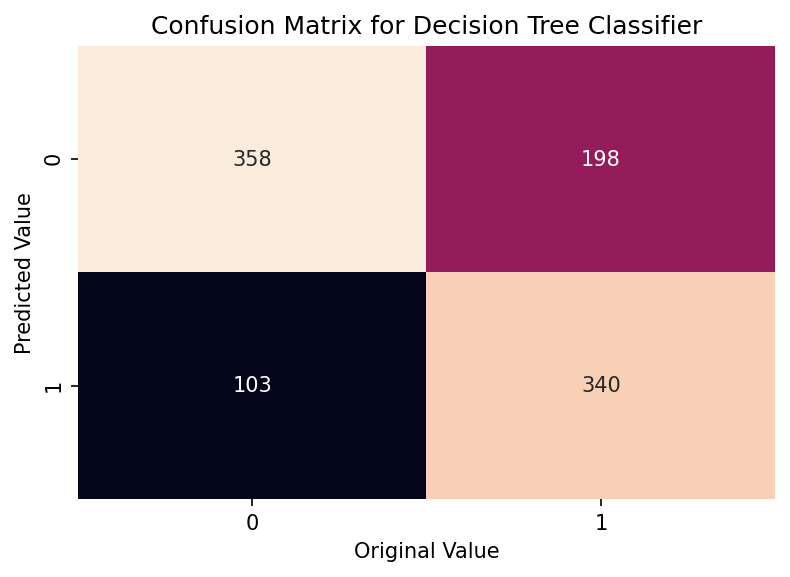

              precision    recall  f1-score   support

           0       0.64      0.78      0.70       461
           4       0.77      0.63      0.69       538

    accuracy                           0.70       999
   macro avg       0.71      0.70      0.70       999
weighted avg       0.71      0.70      0.70       999



In [14]:
########## Decision Tree Classifier

print("\nNow Decision Tree Classifier...")
DTC = DecisionTreeClassifier(max_depth = 5)

# Train Decision Tree Classifer
DTC = DTC.fit(X_Train_DF, Y_Train)

#Predict the response for test dataset
Y_Pred = DTC.predict(X_Test_DF)

print("Accuracy by decision tree ->",(accuracy_score(Y_Test_DF, Y_Pred))*100,'%')
print("Time taken for .fit & .predict ->",time() - start_time)

#### confusion matrix heatmap
plt.figure(dpi=150)
mat = confusion_matrix(Y_Test, Y_Pred)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Decision Tree Classifier')
plt.xlabel('Original Value')
plt.ylabel('Predicted Value')
plt.show()

# precision, recall, F1
print(classification_report(Y_Test, Y_Pred))


## Result for MLP Classifier
* Set the parameters, by default **max_iter** flag is set to 100, which produces errors, increase it to 1000
* Same as before, .fit() , .predict() & accuracy_score()
* Again, Relatively much faster
* Performs multiprocessing


MLP Classifier now.....
Accuracy by MLP Classifier -> 68.66866866866866 %
Time taken for .fit & .predict -> 1205.3631665706635


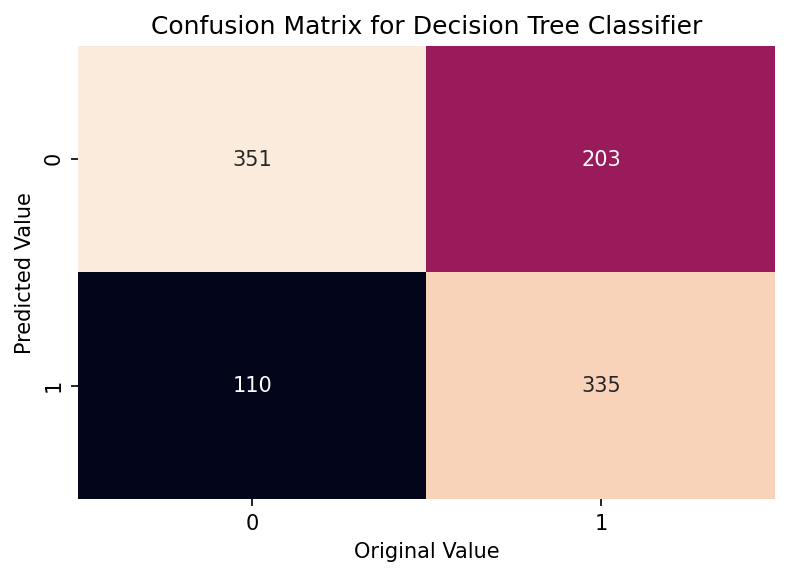

              precision    recall  f1-score   support

           0       0.63      0.76      0.69       461
           4       0.75      0.62      0.68       538

    accuracy                           0.69       999
   macro avg       0.69      0.69      0.69       999
weighted avg       0.70      0.69      0.69       999



In [15]:
print("\nMLP Classifier now.....")

MLPC = MLPClassifier(solver='lbfgs', max_iter=1000, alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

MLPC.fit(X_Train_DF,Y_Train)
Y_Pred = MLPC.predict(X_Test_DF)

print("Accuracy by MLP Classifier ->",(accuracy_score(Y_Test_DF, Y_Pred))*100,'%')
print("Time taken for .fit & .predict ->",time() - start_time)

#### confusion matrix heatmap
plt.figure(dpi=150)
mat = confusion_matrix(Y_Test, Y_Pred)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Decision Tree Classifier')
plt.xlabel('Original Value')
plt.ylabel('Predicted Value')
plt.show()

# precision, recall, F1
print(classification_report(Y_Test, Y_Pred))

# The classification report can produce a warning (depending on the features impelemented) - 
#  _classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
#  _warn_prf(average, modifier, msg_start, len(result))
#
# Some useful links for this -
# https://stackoverflow.com/questions/54150147/classification-report-precision-and-f-score-are-ill-defined
# https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi/47285662
#
